In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc

In [2]:
pc.config.cloudy_exe = '/usr/local/Cloudy/c13.03/source/cloudy.exe'

In [3]:
dir_ = '/tmp'
pc.print_make_file(dir_)

In [4]:
def set_models(dir_, model_name):
    emis_tab = ['H  1  4861',
                'H  1  6563',
                'He 1  5876',
                'N  2  6584',
                'O  1  6300',
                'O II  3726',
                'O II  3729',
                'O  3  5007',
                'TOTL  4363',
                ]   
    a = 2.
    b = 1.0
    thetas = np.linspace(0., 90., 6)
    thetas_rad = np.pi / 180. * thetas
    fact_elli = a * b / np.sqrt((b * np.sin(thetas_rad))**2 + (a * np.cos(thetas_rad))**2)
    rs_in = 16.5 + np.log10(fact_elli)
    densities = 4 - np.log10(fact_elli) * 2
    
    model = pc.CloudyInput()
    model.set_BB(80000., 'q(H)', 47.3)
    model.set_grains()
    model.set_emis_tab(emis_tab)
    
    for theta, r_in, density in zip(thetas, rs_in, densities):
        model.model_name = '{0}/{1}_{2:.0f}'.format(dir_, model_name,theta)
        model.set_cste_density(density)
        model.set_radius(r_in)
        model.set_theta_phi(theta)
        model.print_input(to_file = True, verbose = False)

In [5]:
def def_profiles(m3d):
    """
    This uses the default velocity law (polynome) and default profile (gaussian)
    """
    m3d.set_velocity(params = [20.,60.])
    m3d.config_profile(size_spectrum = 51, vel_max = 50, v_turb = 0.01)    

In [6]:
def def_profiles_user(m3d):
    """
    Use this to define your own expansion velocity
    """
    def velo_polynome(params):
        """
        USer defined expansion velocity
        """
        # params is a 2 elements table, the first element is a table of parameters, the second one the cob_coord
        # which is needed to know r, x, y and z to define the velocity.
        coeffs = params[0]
        cub_coord = params[1]
        tmp = 0.
        for i, coeff in enumerate(coeffs): 
            # for each parameter we add the corresponding coeff * R**power
            tmp = tmp + coeff * cub_coord.r**i
        tmp = tmp / cub_coord.r
        # to avoid the singularity:
        tt = (cub_coord.r == 0.)
        tmp[tt] = 0
        # Projecting on each one of the 3 axes to obtain the velocity components
        vel_x = tmp * cub_coord.x / np.max(cub_coord.x)
        vel_y = tmp * cub_coord.y / np.max(cub_coord.y)
        vel_z = tmp * cub_coord.z / np.max(cub_coord.z)
        return vel_x, vel_y, vel_z
    
    def Hb_prof(x, zeta_0):
        """
        The Hbeta profile is sum of 2 blocks of lines (actually 3 + 4 lines)
        """
        res1 = .41 /zeta_0 / np.sqrt(np.pi) * np.exp(-(((x-2.7)/zeta_0)**2))
        res2 = .59 /zeta_0 / np.sqrt(np.pi) * np.exp(-(((x+2.0)/zeta_0)**2))
        return res1 + res2

    m3d.set_velocity(velocity_law='user', params = [[20.,60.], m3d.cub_coord], user_function = velo_polynome)
    m3d.config_profile(size_spectrum = 41, vel_max = 25, profile_function = Hb_prof, v_turb = 0.01)

In [7]:
def plot_profiles(m3d, x_pos, y_pos):
    plt.plot(m3d.vel_tab,m3d.get_profile('H__1__4861A', axis='x')[:,x_pos,y_pos] * 5, label = r'H$\beta$')
    plt.plot(m3d.vel_tab,m3d.get_profile('N__2__6584A', axis='x')[:,x_pos,y_pos] * 5, label = r'[NII]$\lambda$6584')
    plt.plot(m3d.vel_tab,m3d.get_profile('O__3__5007A', axis='x')[:,x_pos,y_pos], label = r'[OIII]$\lambda$5007')
    plt.legend()

In [8]:
def other_plots(m3d, proj_axis):
    plt.subplot(331)
    plt.imshow(m3d.get_emis('H__1__4861A').sum(axis = proj_axis)*m3d.cub_coord.cell_size)
    plt.title('Hb')
    plt.colorbar()
    
    plt.subplot(332)
    plt.imshow(m3d.get_emis('N__2__6584A').sum(axis = proj_axis)*m3d.cub_coord.cell_size)
    plt.title('[NII]')
    plt.colorbar()
    
    plt.subplot(333)
    plt.imshow(m3d.get_emis('O__3__5007A').sum(axis = proj_axis)*m3d.cub_coord.cell_size)
    plt.title('[OIII]')
    plt.colorbar()
    
    plt.subplot(334)
    plt.imshow(m3d.get_emis('N__2__6584A').sum(axis = proj_axis)/m3d.get_emis('H__1__4861A').sum(axis = proj_axis))
    plt.title('[NII]/Hb')
    plt.colorbar()
    
    plt.subplot(335)
    plt.imshow(m3d.get_emis('O__3__5007A').sum(axis = proj_axis)/m3d.get_emis('H__1__4861A').sum(axis = proj_axis))
    plt.title('[OIII]/Hb')
    plt.colorbar()
    
    plt.subplot(336)
    plt.imshow(m3d.get_ionic('O',1)[n_cut,:,:])
    plt.title('O+ cut')
    plt.colorbar()
    
    plt.subplot(337)
    plt.scatter(m3d.get_ionic('O',1).ravel(),m3d.get_ionic('N',1).ravel()/m3d.get_ionic('O',1).ravel(),
                c=np.abs(m3d.cub_coord.theta.ravel()), edgecolors = 'none')
    plt.title('Colored by |Theta|')
    plt.xlabel('O+ / O')
    plt.ylabel('N+/O+ / N/O')
    plt.colorbar()
    
    plt.subplot(338)
    plt.scatter(m3d.get_ionic('O',1).ravel(),m3d.get_ionic('N',1).ravel()/m3d.get_ionic('O',1).ravel(),
                c=m3d.relative_depth.ravel(),vmin = 0, vmax = 1, edgecolors = 'none')
    plt.title('Colored by position in the nebula')
    plt.xlabel('O+ / O')
    plt.ylabel('N+/O+ / N/O')
    plt.colorbar()
    
    plt.subplot(339)
    C1 = (m3d.get_ionic('N',1)/m3d.get_ionic('O',1)*m3d.get_ionic('N',2))
    C2 = (m3d.get_ionic('N',2))
    tt = (m3d.get_ionic('O',1) == 0)
    C1[tt] = 0
    C2[tt] = 0
    V = C1.sum(axis = proj_axis) / C2.sum(axis = proj_axis)
    plt.imshow(V)
    plt.colorbar()
    plt.title('N+/O+ / N/O weighted by NII')
    plt.contour(V,levels=[1.0])

In [9]:
model_name = "M3D_1"
pc.log_.calling = 'Model3D : ' + model_name
pc.log_.level = 3

In [10]:
dim = 101
n_cut = (dim-1) /2
proj_axis = 0

In [11]:
set_models(dir_, model_name)

     CloudyInput: Input writen in /tmp/M3D_1_0.in
     CloudyInput: Input writen in /tmp/M3D_1_18.in
     CloudyInput: Input writen in /tmp/M3D_1_36.in
     CloudyInput: Input writen in /tmp/M3D_1_54.in
     CloudyInput: Input writen in /tmp/M3D_1_72.in
     CloudyInput: Input writen in /tmp/M3D_1_90.in


In [12]:
pc.print_make_file(dir_ = dir_)
pc.run_cloudy(dir_ = dir_, n_proc = 3, model_name = model_name, use_make = True)

     run_cloudy: running: cd /tmp ; make -j 3 name="M3D_1"
     run_cloudy: ending: cd /tmp ; make -j 3 name="M3D_1"


In [13]:
liste_of_models = pc.load_models('{0}/{1}'.format(dir_, model_name), list_elem=['H', 'He', 'C', 'N', 'O', 'Ar', 'Ne'],  
                                           read_cont = False, read_grains = False)

     CloudyModel /tmp/M3D_1_54: Creating CloudyModel for /tmp/M3D_1_54
     CloudyModel /tmp/M3D_1_54: Be abundance not defined
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.rad read
     CloudyModel /tmp/M3D_1_54: Number of zones: 175
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.phy read
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.ele_H read
     CloudyModel /tmp/M3D_1_54: filling H with 3 columns
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.ele_He read
     CloudyModel /tmp/M3D_1_54: filling He with 3 columns
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.ele_C read
     CloudyModel /tmp/M3D_1_54: filling C with 13 columns
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.ele_N read
     CloudyModel /tmp/M3D_1_54: filling N with 8 columns
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.ele_O read
     CloudyModel /tmp/M3D_1_54: filling O with 12 columns
     CloudyModel /tmp/M3D_1_54: /tmp/M3D_1_54.ele_Ar read
     CloudyModel /tmp/M3D_1_54: filling Ar with 19 columns
     CloudyModel /

In [14]:
m3d = pc.C3D(liste_of_models, dims = [dim, dim, dim], angles = [45,45,0], plan_sym = True)

     C3D: Entering C3D
     CubCoord: building a cube of 101x101x101
     CubCoord: Rotation matrix by 45.0, 45.0, 0.0 degrees.
     C3D: CubCoord done.
     C3D: interp_bi done.
     C3D: Interpolation mesh done
     C3D: All 3D values reset


In [15]:
def_profiles(m3d)

     C3D: get_emis(0) interpolated using numpy-method
     C3D: te interpolated using numpy-method
     C3D: line H__1__4861A : profile computed on axis x
     C3D: get_emis(3) interpolated using numpy-method
     C3D: line N__2__6584A : profile computed on axis x
     C3D: get_emis(7) interpolated using numpy-method
     C3D: line O__3__5007A : profile computed on axis x


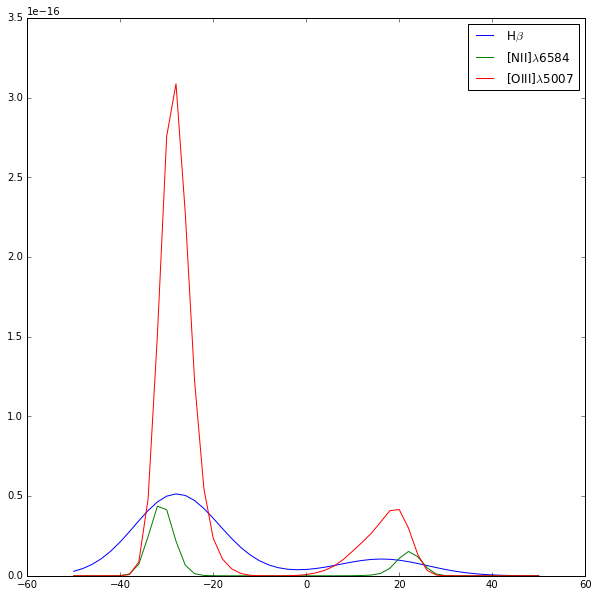

In [16]:
plt.figure(figsize=(10,10))
plot_profiles(m3d, 55, 55)

     C3D: line H__1__4861A : profile computed on axis x


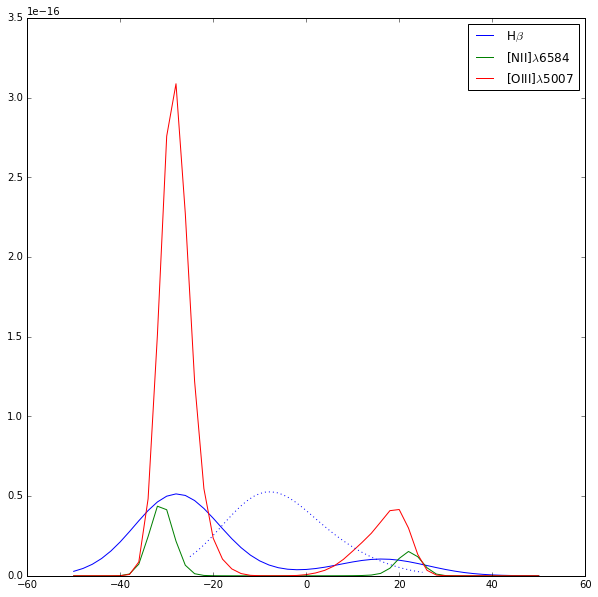

In [17]:
plt.figure(figsize=(10,10))
plot_profiles(m3d, 55, 55)
def_profiles_user(m3d)
plt.plot(m3d.vel_tab,m3d.get_profile('H__1__4861A', axis='x')[:,55,55] * 5, ':b', label = r'H$\beta$')

     C3D: get_ionic('O', 1) interpolated using numpy-method
     C3D: get_ionic('N', 1) interpolated using numpy-method
     C3D: get_ionic('N', 2) interpolated using numpy-method


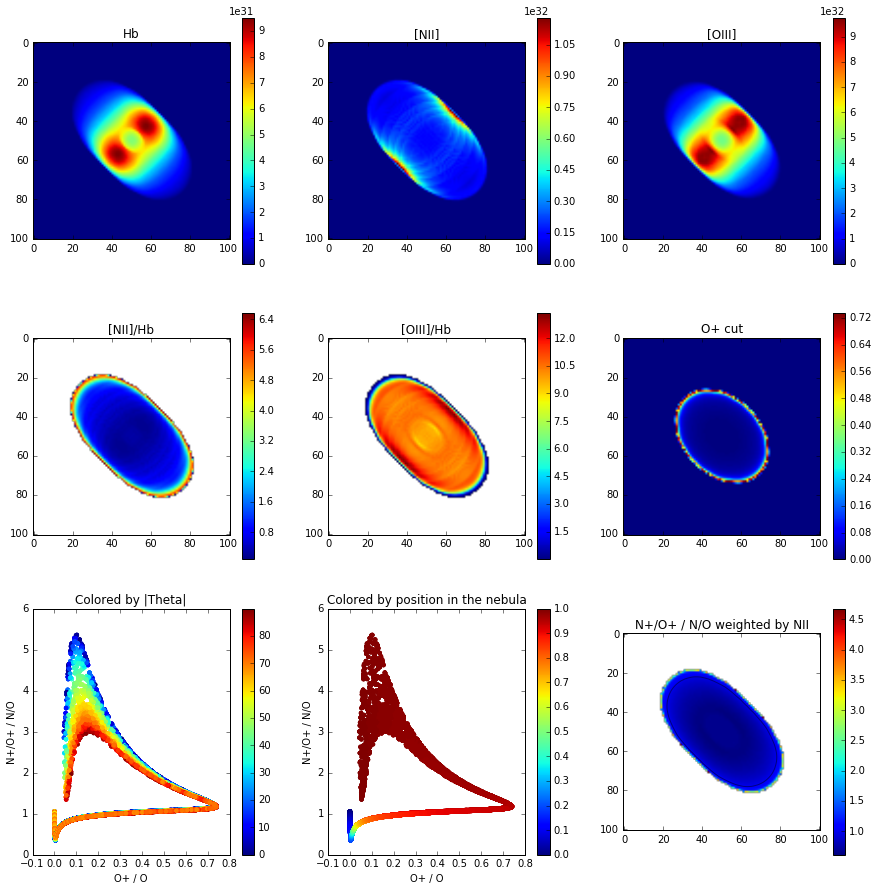

In [18]:
plt.figure(figsize=(15,15))
other_plots(m3d, proj_axis)

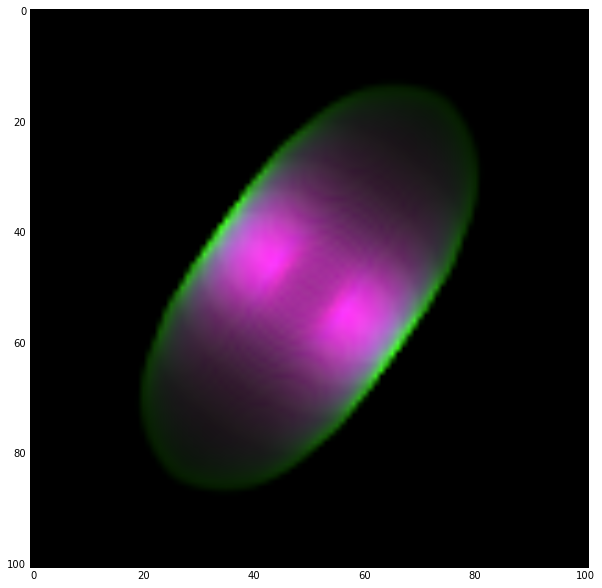

In [19]:
im = m3d.get_RGB(list_emis = [0, 3, 7])
plt.figure(1, figsize=(10,10))
plt.imshow(im)

     C3D: line N__2__6584A : profile computed on axis x


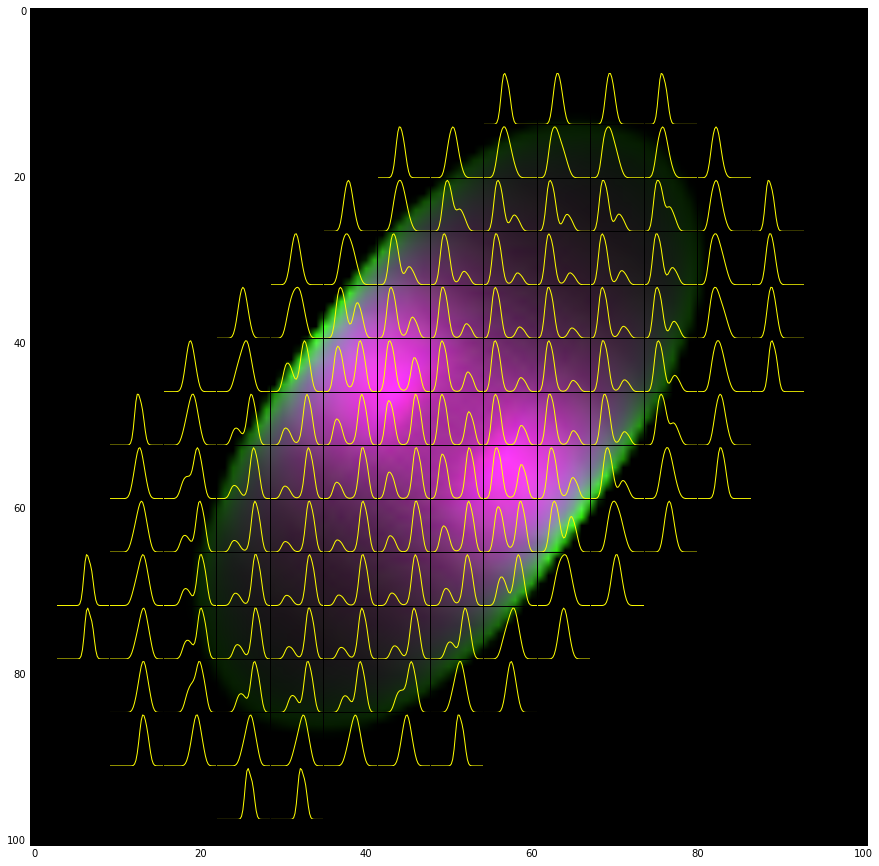

In [20]:
im = m3d.get_RGB(list_emis = [0, 3, 7])
plt.figure(1, figsize=(15,15))
plt.imshow(im)
m3d.plot_profiles(ref = 3, i_fig = 1, Nx=20, Ny=20)